In [ ]:
import tensorflow
print(tensorflow.__version__)

2.8.2


In [ ]:
import pandas as pd

df1 = pd.read_csv('DataUndersampling.csv')
df1.head()

,Remove_noise,sentimen,sentimen_negatif,sentimen_netral,sentimen_positif
0,dokternya baik dan ramah informasi jelas dan d...,positif,0,0,1
1,mantap super cepat pengiriman semoga obatnya j...,positif,0,0,1
2,aplikasinya menyenangkan sekali dokternya rama...,positif,0,0,1
3,berterimakasih sekali sama halodoc beli obat m...,positif,0,0,1
4,terima kasih halo doc sangat membantu sekali t...,positif,0,0,1


In [ ]:
sentimen = df1['Remove_noise'].values
label = df1[['sentimen_negatif', 'sentimen_netral',
       'sentimen_positif']].values

In [ ]:
# Membagi data menjadi 80% data train dan 20% data test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentimen, label, test_size=0.2)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer # Mengimport tokenizer untuk preprocessing kata-kata
from tensorflow.keras.preprocessing.sequence import pad_sequences # Mengimport pad_sequences untuk preprocessing kata

# Memasukkan fungsi tokenizer yang didalamnya terdapat parameter untuk menyimpan 6500 kata yang sering muncul
tokenizer = Tokenizer(num_words=6500, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_test)

# Mengubah token jadi sequence 
sekuens_latih = tokenizer.texts_to_sequences(x_train)
sekuens_test = tokenizer.texts_to_sequences(x_test)

# Menggunakan padding agar sequence menjadi sama panjang
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [ ]:
tokenIndexKata=tokenizer.word_index
print(tokenIndexKata)

{'<OOV>': 1, 'sangat': 2, 'dan': 3, 'yang': 4, 'saya': 5, 'tidak': 6, 'membantu': 7, 'aplikasi': 8, 'dokter': 9, 'ini': 10, 'di': 11, 'bisa': 12, 'halodoc': 13, 'dengan': 14, 'untuk': 15, 'obat': 16, 'cepat': 17, 'sekali': 18, 'kasih': 19, 'ada': 20, 'dokternya': 21, 'tapi': 22, 'sudah': 23, 'konsultasi': 24, 'bagus': 25, 'terima': 26, 'ke': 27, 'juga': 28, 'ramah': 29, 'banget': 30, 'dari': 31, 'lagi': 32, 'sakit': 33, 'baik': 34, 'rumah': 35, 'terimakasih': 36, 'karena': 37, 'apa': 38, 'langsung': 39, 'harus': 40, 'kalau': 41, 'respon': 42, 'jadi': 43, 'saja': 44, 'kita': 45, 'sat': 46, 'lebih': 47, 'buat': 48, 'chat': 49, 'perlu': 50, 'sama': 51, 'mudah': 52, 'banyak': 53, 'pakai': 54, 'seperti': 55, 'terus': 56, 'kesehatan': 57, 'semoga': 58, 'bermanfat': 59, 'pelayanan': 60, 'selalu': 61, 'sampai': 62, 'lama': 63, 'dalam': 64, 'beli': 65, 'waktu': 66, 'cukup': 67, 'semua': 68, 'belum': 69, 'dapat': 70, 'tanpa': 71, 'resep': 72, 'baru': 73, 'konsul': 74, 'bayar': 75, 'pandemi': 76,

In [ ]:
# Membuat kelas dan fungsi agar proses training berhenti saat akurasi validasi model telah mencapai 85%
import tensorflow as tf

class myCallBack(tf.keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= 0.85):
            print("\nAkurasi validasi telah mencapai > 85%!")
            self.model.stop_training = True
myCallBack = myCallBack()

In [ ]:
import os 
from tensorflow.keras.callbacks import ModelCheckpoint

# Simpan model
save_direc = os.path.join(os.getcwd(), 'Dataset\Cobadoang')
model_name = 'model_baru.ckpt'

# Membuat directory untuk menyimpan model
if not os.path.isdir(save_direc):
    os.makedirs(save_direc)

# Menggabungkan directory dengan model
modelpath = os.path.join(save_direc, model_name)

checkpoint = ModelCheckpoint(filepath = modelpath, verbose = 2, monitor='val_accuracy',
                             save_best_only = True, save_weights_only = True)#,save_freq=1)

In [ ]:
from tensorflow.keras import regularizers # Library untuk mencegah overfitting pada model
from tensorflow.keras.optimizers import RMSprop # mengimport optimizer untuk model

# Membuat model Sequential dengan Bidirectional LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(6500, 32), # 6500 input & 32 layer embedding
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)), # 64 layer LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # 32 layer LSTM
    tf.keras.layers.Dropout(0.2), # dropout agar model tidak overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'), # Menambah layer dan menggunakan relu sebagai fungsi aktivasi
    tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.3), # dropout agar model tidak overfitting
    tf.keras.layers.Dense(3, activation='softmax') # Outputnya adalah 3 dan karena kategorikal menggunakan aktivasi softmax
])

model.summary() # Melihat shape dan parameter dari model yang dibuat
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0001),metrics=['accuracy']) # Menggunakan optimizer RMSprop dengan learning rate 0.0001

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          208000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [ ]:
#batch_size = 16
history = model.fit(padded_latih, y_train, validation_data=(padded_test, y_test), epochs=100,#batch_size=batch_size,
                    steps_per_epoch= 30, callbacks=[myCallBack, checkpoint], verbose=2)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.46827, saving model to /content/Dataset\Cobadoang/model_baru.ckpt
30/30 - 18s - loss: 1.2037 - accuracy: 0.3970 - val_loss: 1.1940 - val_accuracy: 0.4683 - 18s/epoch - 585ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.46827 to 0.50425, saving model to /content/Dataset\Cobadoang/model_baru.ckpt
30/30 - 1s - loss: 1.1826 - accuracy: 0.4738 - val_loss: 1.1617 - val_accuracy: 0.5042 - 1s/epoch - 39ms/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.50425
30/30 - 1s - loss: 1.1346 - accuracy: 0.4908 - val_loss: 1.0982 - val_accuracy: 0.4823 - 1s/epoch - 38ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.50425 to 0.51574, saving model to /content/Dataset\Cobadoang/model_baru.ckpt
30/30 - 1s - loss: 1.0763 - accuracy: 0.5017 - val_loss: 1.0423 - val_accuracy: 0.5157 - 1s/epoch - 39ms/step
Epoch 5/100

Epoch 5: val_accuracy improved from 0.51574 to 0.54773, saving model to /content/Dataset\Cobadoang/

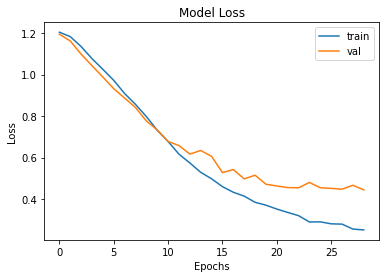

In [ ]:
# Menampilkan plot loss dari model

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

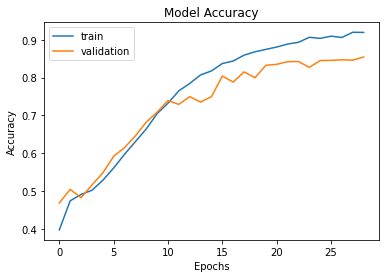

In [ ]:
# Menampilkan plot akurasi dari model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
loss, acc = model.evaluate(padded_test, y_test, verbose=1)
                            #batch_size=batch_size)
print("loss:", loss)
print("Validation accuracy:", acc)

63/63 [==============================] - 1s 8ms/step - loss: 0.4447 - accuracy: 0.8546
loss: 0.44471219182014465
Validation accuracy: 0.8545727133750916


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score, f1_score, recall_score
import numpy as np

def model_evaluate(): 
    # predict class with test set
    predict_x=model.predict(padded_test, verbose=0)
    classes_x=np.argmax(predict_x,axis=1)
    y_pred_test =  classes_x
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

Accuracy:	85.5%


              precision    recall  f1-score   support

           0       0.86      0.91      0.88       679
           1       0.80      0.74      0.77       649
           2       0.90      0.91      0.91       673

    accuracy                           0.85      2001
   macro avg       0.85      0.85      0.85      2001
weighted avg       0.85      0.85      0.85      2001



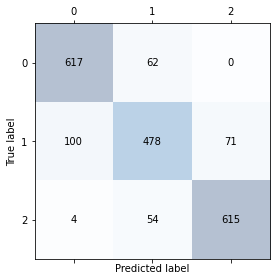

In [ ]:
model_evaluate()

In [ ]:
import numpy as np

twt = ['suka bangettt sama halodoc dokternya ramah ramah']
print(twt)
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=29, dtype='int32', value=0)
sentiment = model.predict(twt)[0]
if(np.argmax(sentiment) == 0):
    print('Sentimen: Negatif')
elif (np.argmax(sentiment) == 1):
    print('Sentimen: Netral')
else :
    print('Sentimen: Positif')
print(sentiment)

['suka bangettt sama halodoc dokternya ramah ramah']
Sentimen: Positif
[2.1281883e-05 1.7244181e-02 9.8273450e-01]


In [ ]:
twt = ['saya baru saja mencoba untuk berkonsultasi dengan dokter saya juga sudah menyelesaikan pembayaran tapi ketika dihubungkan dengan dokter yang bersangkutan tidak juga kunjung tersambung sampai saya mencoba berkali² uang saya hangus percuma']
print(twt)
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=29, dtype='int32', value=0)
sentiment = model.predict(twt)[0]
print(sentiment)
if(np.argmax(sentiment) == 0):
    print('Sentimen: Negatif')
elif (np.argmax(sentiment) == 1):
    print('Sentimen: Netral')
else :
    print('Sentimen: Positif')

['saya baru saja mencoba untuk berkonsultasi dengan dokter saya juga sudah menyelesaikan pembayaran tapi ketika dihubungkan dengan dokter yang bersangkutan tidak juga kunjung tersambung sampai saya mencoba berkali² uang saya hangus percuma']
[9.6531469e-01 3.4392323e-02 2.9298049e-04]
Sentimen: Negatif


In [ ]:
import pickle

# saving
with open('tokenizer_data.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model.save('ModelP3D02.h5')